<a href="https://colab.research.google.com/github/shreyansh-35/Osteoporosis_disease_detection_using_fusion_model/blob/main/EfficientNetV2B0_Fusion_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import numpy as np
from PIL import Image
import os

from tensorflow.keras.layers import Dense, Input, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input
from tensorflow.keras.applications import EfficientNetV2B0

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [ ]:
image_generator = ImageDataGenerator(preprocessing_function = preprocess_input)

In [ ]:
dataset = image_generator.flow_from_directory(
    directory = '/content/drive/MyDrive/osteoporosis dataset',
    target_size = (224,224),
    batch_size = 20,
    shuffle = True
)

Found 372 images belonging to 2 classes.


In [ ]:
print("Number of batches:", len(dataset))
print("Number of samples in the dataset:", dataset.samples)
print("Class indices:", dataset.class_indices)

# Iterate through batches and print information about each batch
for i, (batch_images, batch_labels) in enumerate(dataset):
    print(f"Batch {i + 1}:")
    print("  Batch shape:", batch_images.shape)
    print("  Label shape:", batch_labels.shape)

    # Add more code here if you want to inspect the actual content of the batches
    # For example, you can print the first image in the batch:
    # print("  First image in the batch:")
    # print(batch_images[0])

    if i == 2:  # Stop after printing the first 3 batches for demonstration purposes
        break

Number of batches: 19
Number of samples in the dataset: 372
Class indices: {'normal': 0, 'osteoporosis': 1}
Batch 1:
  Batch shape: (20, 224, 224, 3)
  Label shape: (20, 2)
Batch 2:
  Batch shape: (20, 224, 224, 3)
  Label shape: (20, 2)
Batch 3:
  Batch shape: (20, 224, 224, 3)
  Label shape: (20, 2)


In [ ]:
from sklearn.model_selection import train_test_split

# Assuming dataset is an iterator providing batches (x_batch, y_batch)
# Adjust this based on the actual structure of your dataset

# Collect all batches
x,y = [], []
for _ in range(len(dataset)):
    x_batch, y_batch = next(dataset)
    x.append(x_batch)
    y.append(y_batch)

# Concatenate batches to obtain all data
x = np.concatenate(x, axis=0)
y = np.concatenate(y, axis=0)

# Split the dataset into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

print(len(x))
print(len(y))

print(x_train.shape)
print(y_train.shape)

print(x_test.shape)
print(y_test.shape)

# print(x)
# print(y)

372
372
(297, 224, 224, 3)
(297, 2)
(75, 224, 224, 3)
(75, 2)


In [ ]:
image_input = Input(shape=(224, 224, 3))

model = EfficientNetV2B0(
    include_top=True,
    weights='imagenet',
    input_tensor=image_input,
    input_shape=None,
    # include_preprocessing=True,
    # pooling='max',
    # classes=2,
    # classifier_activation="softmax",
)
# model.layers[0].trainable = False
model.summary()

Model: "efficientnetv2-b0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 224, 224, 3)          0         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 stem_conv (Conv2D)          (None, 112, 112, 32)         864       ['normalizatio

In [ ]:
last_layer = model.get_layer('avg_pool').output
additional_layer1 = Dense(512, activation = 'relu')(last_layer)
additional_layer2 = Dense(64, activation='softmax', name='second_last')(additional_layer1)
additional_layer3 = Dense(2, activation='softmax', name='output')(additional_layer2)

custom_model = Model(image_input,additional_layer3)
custom_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 224, 224, 3)          0         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 stem_conv (Conv2D)          (None, 112, 112, 32)         864       ['normalization[0][0]']   

In [ ]:
for layer in custom_model.layers[:-3]:
	layer.trainable = False

custom_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 224, 224, 3)          0         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 stem_conv (Conv2D)          (None, 112, 112, 32)         864       ['normalization[0][0]']   

In [ ]:
# Compile the model
custom_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the model on the training set
# history = model.fit(x_train, y_train, epochs=10, batch_size=40, validation_split=0.2)

from keras.callbacks import ModelCheckpoint
filepath="/content/drive/MyDrive/Model Check Points/weights_best_EfficientNetV2B0.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

history = custom_model.fit(x_train, y_train, validation_split=0.2, epochs=20, batch_size=16,
                          callbacks=callbacks_list)

Epoch 1/20
15/15 [==============================] - ETA: 0s - loss: 0.6714 - accuracy: 0.6118
Epoch 1: val_accuracy improved from -inf to 0.81667, saving model to /content/drive/MyDrive/Model Check Points/weights_best_EfficientNetV2B0.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


15/15 [==============================] - 33s 1s/step - loss: 0.6714 - accuracy: 0.6118 - val_loss: 0.6323 - val_accuracy: 0.8167
Epoch 2/20
15/15 [==============================] - ETA: 0s - loss: 0.6391 - accuracy: 0.7722
Epoch 2: val_accuracy did not improve from 0.81667
15/15 [==============================] - 18s 1s/step - loss: 0.6391 - accuracy: 0.7722 - val_loss: 0.6402 - val_accuracy: 0.7667
Epoch 3/20
15/15 [==============================] - ETA: 0s - loss: 0.6339 - accuracy: 0.7764
Epoch 3: val_accuracy improved from 0.81667 to 0.83333, saving model to /content/drive/MyDrive/Model Check Points/weights_best_EfficientNetV2B0.hdf5
15/15 [==============================] - 17s 1s/step - loss: 0.6339 - accuracy: 0.7764 - val_loss: 0.6183 - val_accuracy: 0.8333
Epoch 4/20
15/15 [==============================] - ETA: 0s - loss: 0.6296 - accuracy: 0.7764
Epoch 4: val_accuracy did not improve from 0.83333
15/15 [==============================] - 16s 1s/step - loss: 0.6296 - accuracy: 

In [ ]:
custom_model.load_weights(filepath)

In [ ]:
# Evaluate the model on the testing set
test_loss, test_accuracy = custom_model.evaluate(x_test, y_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

3/3 [==============================] - 4s 1s/step - loss: 0.6263 - accuracy: 0.7867
Test Loss: 0.6263
Test Accuracy: 0.7867


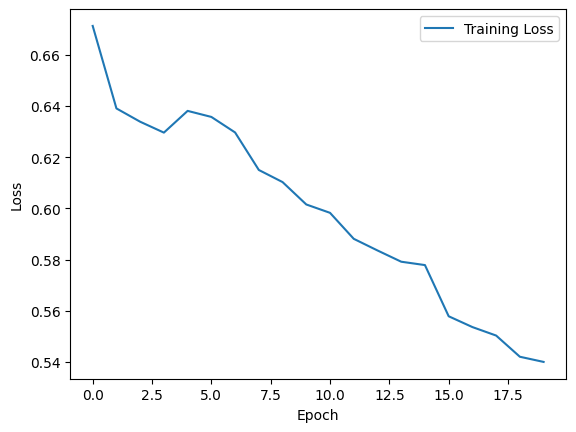

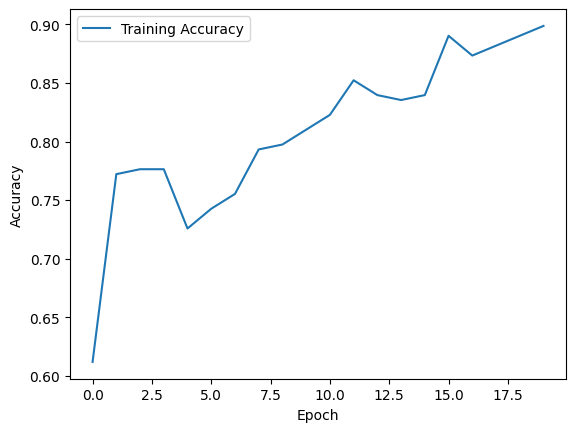

In [ ]:
import matplotlib.pyplot as plt

# Plot training loss
plt.plot(history.history['loss'], label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
from sklearn import metrics

predictions_test = custom_model.predict(x_test)
# print(predictions_test.shape)
# print(predictions_test)

# This line creates an array y_pred with the same shape as predictions_test but filled with zeros.
y_pred = np.zeros_like(predictions_test)

# Now, y_pred array will be used to convert the predicted probabilities into binary predictions.
# In other words, for each row, it indicates which column has the highest probability and convert in into 1.
y_pred[np.arange(len(predictions_test)), predictions_test.argmax(1)] = 1

print(metrics.classification_report(y_test,y_pred))

3/3 [==============================] - 8s 2s/step
              precision    recall  f1-score   support

           0       0.72      0.89      0.79        35
           1       0.88      0.70      0.78        40

   micro avg       0.79      0.79      0.79        75
   macro avg       0.80      0.79      0.79        75
weighted avg       0.80      0.79      0.79        75
 samples avg       0.79      0.79      0.79        75



In [ ]:
print(y_pred.shape)
print(y_pred)

(75, 2)
[[0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]]


Confusion Matrix: 
 [[31  4]
 [12 28]]
Normalized Confusion Matrix:
 [[0.88571429 0.11428571]
 [0.3        0.7       ]]


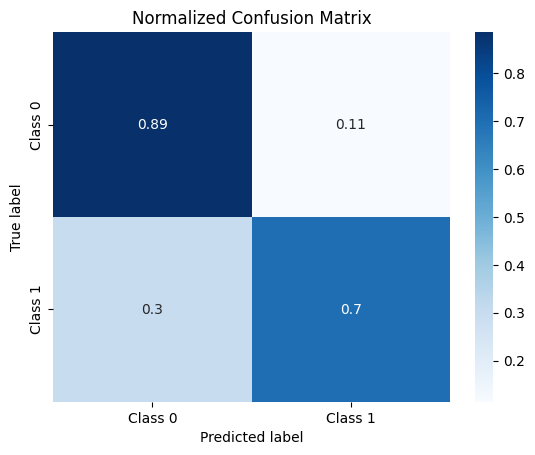

In [ ]:
import seaborn as sns

cnf_matrix = metrics.confusion_matrix(y_test.argmax(axis =1),y_pred.argmax(axis =1))
print("Confusion Matrix: \n",cnf_matrix)

# Normalize confusion matrix
cm_normalized = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
print("Normalized Confusion Matrix:\n",cm_normalized)

classes = ['Class 0', 'Class 1']

# Plot normalized confusion matrix using Seaborn
sns.heatmap(cm_normalized, annot=True, cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

<ipython-input-20-2539ef95f772>:33: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


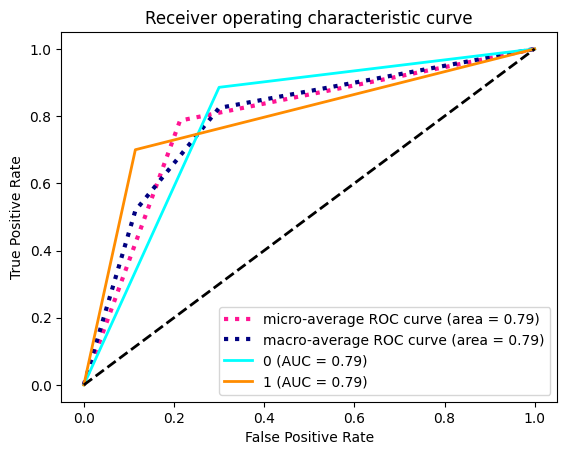

In [ ]:
from itertools import cycle
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp

def plot_AUC_ROC(y_true, y_pred):
    n_classes = 2

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


    # Compute macro-average ROC curve and ROC area

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])


    plt.plot(fpr["micro"], tpr["micro"],
            label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]),
            color='deeppink', linestyle='dotted', linewidth=3)

    plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=3)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, linewidth=2,label='{0} (AUC = {1:0.2f})'.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', linewidth=2) # Diognal line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic curve')
    plt.legend(loc="lower right")

plot_AUC_ROC(y_test,y_pred)

## **Removing Top layers from Custom model**

In [ ]:
# Extract features from EfficientNetV2B0 model
final_layer = custom_model.get_layer('top_activation').output
efficientnet_model = Model(inputs=custom_model.input, outputs=final_layer)
efficientnet_model.summary()

X_train_features = efficientnet_model.predict(x_train)
X_test_features = efficientnet_model.predict(x_test)

print(X_train_features.shape)
print(X_test_features.shape)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 224, 224, 3)          0         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 stem_conv (Conv2D)          (None, 112, 112, 32)         864       ['normalization[0][0]'] 

In [ ]:
X_train_features_flat = X_train_features.reshape(X_train_features.shape[0], -1)
X_test_features_flat = X_test_features.reshape(X_test_features.shape[0], -1)

y_train_flattened = y_train.argmax(axis=1)
y_test_flattened = y_test.argmax(axis=1)

print(X_train_features_flat.shape)
print(X_test_features_flat.shape)

print(y_train_flattened.shape)
print(y_test_flattened.shape)

(297, 62720)
(75, 62720)
(297,)
(75,)


## **Prediction through Decision Tree Classifier**

In [ ]:
# Train a Decision Tree classifier
from sklearn.tree import DecisionTreeClassifier

decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train_features_flat, y_train)

decision_tree_predictions = decision_tree.predict(X_test_features_flat)

# Calculate accuracy
decision_tree_accuracy = accuracy_score(y_test, decision_tree_predictions)
print("Decision Tree Accuracy:", decision_tree_accuracy)

Decision Tree Accuracy: 0.6133333333333333


In [ ]:
from sklearn import metrics

# Generate classification report with zero_division parameter set to "warn"
report = metrics.classification_report(y_test, decision_tree_predictions)

# Print the report
print(report)

              precision    recall  f1-score   support

           0       0.57      0.69      0.62        35
           1       0.69      0.55      0.61        40

   micro avg       0.62      0.61      0.62        75
   macro avg       0.63      0.62      0.62        75
weighted avg       0.63      0.61      0.62        75
 samples avg       0.61      0.61      0.61        75



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion Matrix: 
 [[25 10]
 [18 22]]
Normalized Confusion Matrix:
 [[0.71428571 0.28571429]
 [0.45       0.55      ]]


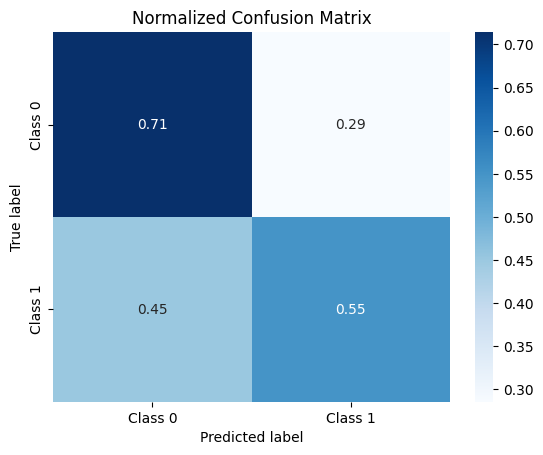

In [ ]:
import seaborn as sns

cnf_matrix = metrics.confusion_matrix(y_test.argmax(axis =1),decision_tree_predictions.argmax(axis =1))
print("Confusion Matrix: \n",cnf_matrix)

# Normalize confusion matrix
cm_normalized = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
print("Normalized Confusion Matrix:\n",cm_normalized)

classes = ['Class 0', 'Class 1']

# Plot normalized confusion matrix using Seaborn
sns.heatmap(cm_normalized, annot=True, cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

<ipython-input-59-5f3bbd1a0e9d>:33: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


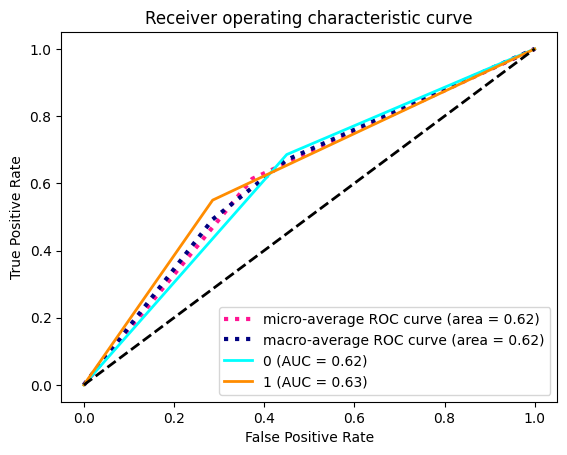

In [ ]:
from itertools import cycle
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp

def plot_AUC_ROC(y_true, y_pred):
    n_classes = 2

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


    # Compute macro-average ROC curve and ROC area

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])


    plt.plot(fpr["micro"], tpr["micro"],
            label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]),
            color='deeppink', linestyle='dotted', linewidth=3)

    plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=3)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, linewidth=2,label='{0} (AUC = {1:0.2f})'.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', linewidth=2) # Diognal line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic curve')
    plt.legend(loc="lower right")

plot_AUC_ROC(y_test,decision_tree_predictions)

## **Prediction through Random Forest Classifier**

In [ ]:
# Train Random Forest classifier
from sklearn.ensemble import RandomForestClassifier

rf_classifier = RandomForestClassifier(n_estimators=200)
rf_classifier.fit(X_train_features_flat, y_train)

# Evaluate Random Forest classifier
rf_predictions = rf_classifier.predict(X_test_features_flat)

# Calculate accuracy
rf_accuracy = accuracy_score(y_test, rf_predictions)
print("Random Forest Accuracy:", rf_accuracy)

Random Forest Accuracy: 0.84


In [ ]:
from sklearn import metrics

# Generate classification report with zero_division parameter set to "warn"
report = metrics.classification_report(y_test, rf_predictions)

# Print the report
print(report)

              precision    recall  f1-score   support

           0       0.87      0.77      0.82        35
           1       0.82      0.90      0.86        40

   micro avg       0.84      0.84      0.84        75
   macro avg       0.84      0.84      0.84        75
weighted avg       0.84      0.84      0.84        75
 samples avg       0.84      0.84      0.84        75



Confusion Matrix: 
 [[27  8]
 [ 4 36]]
Normalized Confusion Matrix:
 [[0.77142857 0.22857143]
 [0.1        0.9       ]]


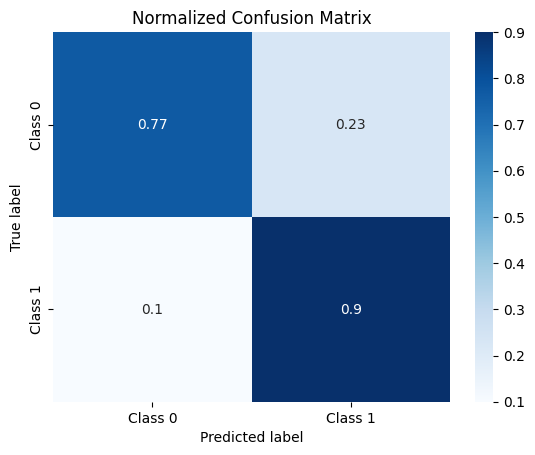

In [ ]:
import seaborn as sns

cnf_matrix = metrics.confusion_matrix(y_test.argmax(axis =1),rf_predictions.argmax(axis =1))
print("Confusion Matrix: \n",cnf_matrix)

# Normalize confusion matrix
cm_normalized = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
print("Normalized Confusion Matrix:\n",cm_normalized)

classes = ['Class 0', 'Class 1']

# Plot normalized confusion matrix using Seaborn
sns.heatmap(cm_normalized, annot=True, cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

<ipython-input-70-9d899c79a1e0>:33: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


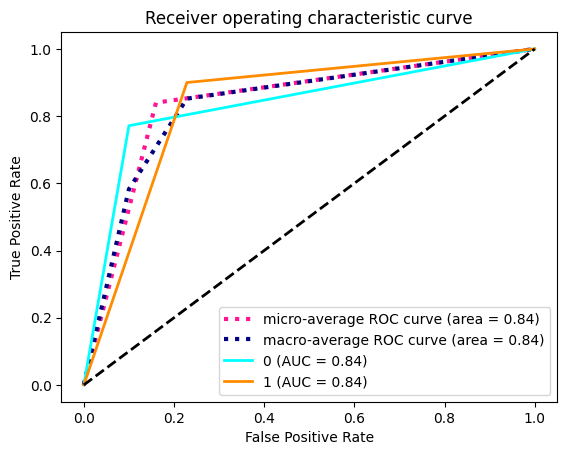

In [ ]:
from itertools import cycle
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp

def plot_AUC_ROC(y_true, y_pred):
    n_classes = 2

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


    # Compute macro-average ROC curve and ROC area

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])


    plt.plot(fpr["micro"], tpr["micro"],
            label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]),
            color='deeppink', linestyle='dotted', linewidth=3)

    plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=3)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, linewidth=2,label='{0} (AUC = {1:0.2f})'.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', linewidth=2) # Diognal line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic curve')
    plt.legend(loc="lower right")

plot_AUC_ROC(y_test,rf_predictions)

## **Prediction through Support Vector Machine Classifier**

In [ ]:
# Train SVM classifier
from sklearn.svm import SVC

svm_classifier = SVC(kernel='linear')
svm_classifier.fit(X_train_features_flat, y_train_flattened)

# Predictions on test set
svm_predictions = svm_classifier.predict(X_test_features_flat)

# Calculate accuracy
svm_accuracy = accuracy_score(y_test_flattened, svm_predictions)
print("SVM Accuracy:", svm_accuracy)

SVM Accuracy: 0.8133333333333334


In [ ]:
from sklearn import metrics

# Generate classification report with zero_division parameter set to "warn"
report = metrics.classification_report(y_test_flattened, svm_predictions)

# Print the report
print(report)

              precision    recall  f1-score   support

           0       0.76      0.89      0.82        35
           1       0.88      0.75      0.81        40

    accuracy                           0.81        75
   macro avg       0.82      0.82      0.81        75
weighted avg       0.82      0.81      0.81        75



Confusion Matrix: 
 [[31  4]
 [10 30]]
Normalized Confusion Matrix:
 [[0.88571429 0.11428571]
 [0.25       0.75      ]]


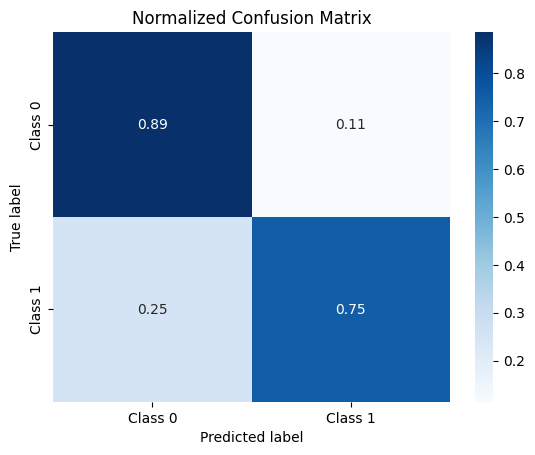

In [ ]:
import seaborn as sns

cnf_matrix = metrics.confusion_matrix(y_test_flattened, svm_predictions)
print("Confusion Matrix: \n",cnf_matrix)

# Normalize confusion matrix
cm_normalized = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
print("Normalized Confusion Matrix:\n",cm_normalized)

classes = ['Class 0', 'Class 1']

# Plot normalized confusion matrix using Seaborn
sns.heatmap(cm_normalized, annot=True, cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [ ]:
# print(y_test_flattened)
# print(y_test)

print(svm_predictions)

svm_matrix = np.zeros((svm_predictions.size, 2))

for i in range(0,svm_predictions.size):
  if(svm_predictions[i] == 1):
    svm_matrix[i][1] = 1
  else:
    svm_matrix[i][0] = 1

print(svm_matrix)

[0 0 0 0 1 1 1 0 1 0 0 0 0 1 1 0 0 1 0 0 1 0 1 0 1 1 1 0 0 1 0 1 1 1 1 0 1
 0 1 0 0 1 0 0 0 1 1 1 1 0 1 0 0 0 1 1 1 1 0 0 0 0 1 0 1 1 0 0 0 0 0 1 0 1
 0]
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]]


<ipython-input-84-0ad35b60b44d>:33: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


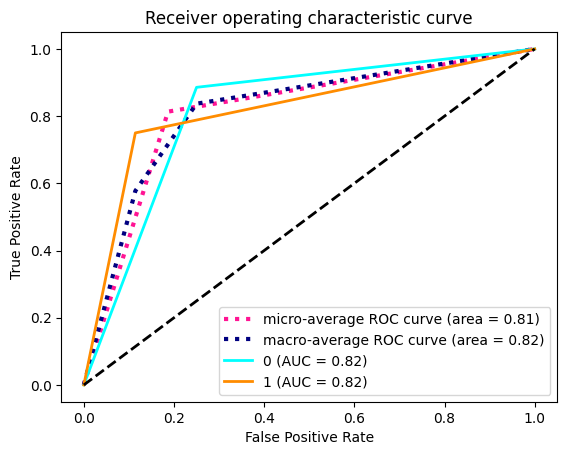

In [ ]:
from itertools import cycle
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp

def plot_AUC_ROC(y_true, y_pred):
    n_classes = 2

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


    # Compute macro-average ROC curve and ROC area

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])


    plt.plot(fpr["micro"], tpr["micro"],
            label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]),
            color='deeppink', linestyle='dotted', linewidth=3)

    plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=3)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, linewidth=2,label='{0} (AUC = {1:0.2f})'.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', linewidth=2) # Diognal line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic curve')
    plt.legend(loc="lower right")

plot_AUC_ROC(y_test,svm_matrix)

## **Prediction through Naive Bayes Classifier**

In [ ]:
from sklearn.naive_bayes import GaussianNB

# Define and train the Naive Bayes classifier
naive_bayes = GaussianNB()
naive_bayes.fit(X_train_features_flat, y_train_flattened)

# Make predictions on the test set
nb_predictions = naive_bayes.predict(X_test_features_flat)

# Evaluate the performance of the Naive Bayes classifier
nb_accuracy = accuracy_score(y_test_flattened, nb_predictions)
print("Naive Bayes Accuracy:", nb_accuracy)

Naive Bayes Accuracy: 0.8


In [ ]:
from sklearn import metrics

# Generate classification report with zero_division parameter set to "warn"
report = metrics.classification_report(y_test_flattened, nb_predictions)

# Print the report
print(report)

              precision    recall  f1-score   support

           0       0.88      0.66      0.75        35
           1       0.76      0.93      0.83        40

    accuracy                           0.80        75
   macro avg       0.82      0.79      0.79        75
weighted avg       0.82      0.80      0.80        75



Confusion Matrix: 
 [[23 12]
 [ 3 37]]
Normalized Confusion Matrix:
 [[0.65714286 0.34285714]
 [0.075      0.925     ]]


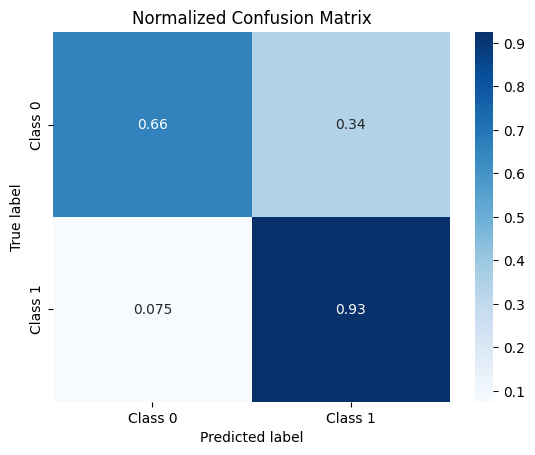

In [ ]:
import seaborn as sns

cnf_matrix = metrics.confusion_matrix(y_test_flattened, nb_predictions)
print("Confusion Matrix: \n",cnf_matrix)

# Normalize confusion matrix
cm_normalized = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
print("Normalized Confusion Matrix:\n",cm_normalized)

classes = ['Class 0', 'Class 1']

# Plot normalized confusion matrix using Seaborn
sns.heatmap(cm_normalized, annot=True, cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [ ]:
# print(y_test_flattened)
# print(y_test)

print(nb_predictions)

nb_matrix = np.zeros((nb_predictions.size, 2))

for i in range(0,nb_predictions.size):
  if(nb_predictions[i] == 1):
    nb_matrix[i][1] = 1
  else:
    nb_matrix[i][0] = 1

print(nb_matrix)

[1 0 0 1 1 1 1 1 1 0 1 0 0 1 1 1 0 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 0 0 1 0 0 0 1 1 0 1 1 1 0 0 1 1 1 1 1 0 1 1 0 1 0 1 1 0 1 0 0 0 1 0 1
 0]
[[0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]]


<ipython-input-91-bdc9504367ea>:33: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


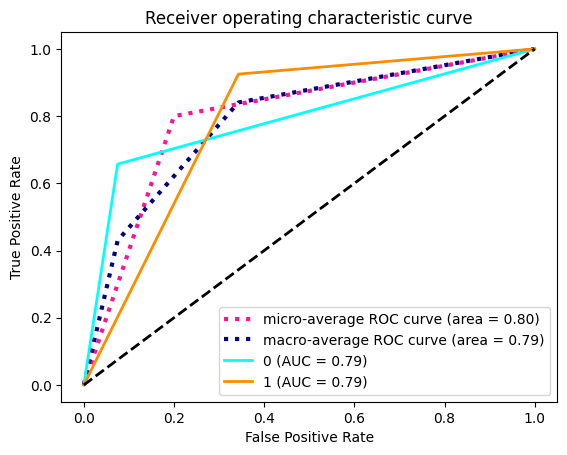

In [ ]:
from itertools import cycle
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp

def plot_AUC_ROC(y_true, y_pred):
    n_classes = 2

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


    # Compute macro-average ROC curve and ROC area

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])


    plt.plot(fpr["micro"], tpr["micro"],
            label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]),
            color='deeppink', linestyle='dotted', linewidth=3)

    plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=3)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, linewidth=2,label='{0} (AUC = {1:0.2f})'.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', linewidth=2) # Diognal line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic curve')
    plt.legend(loc="lower right")

plot_AUC_ROC(y_test,nb_matrix)

## **Prediction through Logistic Regression Classifier**

In [ ]:
# Create an instance of the LogisticRegression class

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# Scale the input features
scaler = StandardScaler()
X_train_features_scaled = scaler.fit_transform(X_train_features_flat)
X_test_features_scaled = scaler.transform(X_test_features_flat)

# Create and train the logistic regression model with increased max_iter
logistic_regression = LogisticRegression(max_iter=1000)
logistic_regression.fit(X_train_features_scaled, y_train_flattened)

# Make predictions and evaluate the model
logistic_regression_predictions = logistic_regression.predict(X_test_features_scaled)

logistic_regression_accuracy = accuracy_score(y_test_flattened, logistic_regression_predictions)
print("Logistic Regression Accuracy:", logistic_regression_accuracy)


Logistic Regression Accuracy: 0.7733333333333333


In [ ]:
from sklearn import metrics

# Generate classification report with zero_division parameter set to "warn"
report = metrics.classification_report(y_test_flattened, logistic_regression_predictions)

# Print the report
print(report)

              precision    recall  f1-score   support

           0       0.74      0.80      0.77        35
           1       0.81      0.75      0.78        40

    accuracy                           0.77        75
   macro avg       0.77      0.78      0.77        75
weighted avg       0.78      0.77      0.77        75



Confusion Matrix: 
 [[28  7]
 [10 30]]
Normalized Confusion Matrix:
 [[0.8  0.2 ]
 [0.25 0.75]]


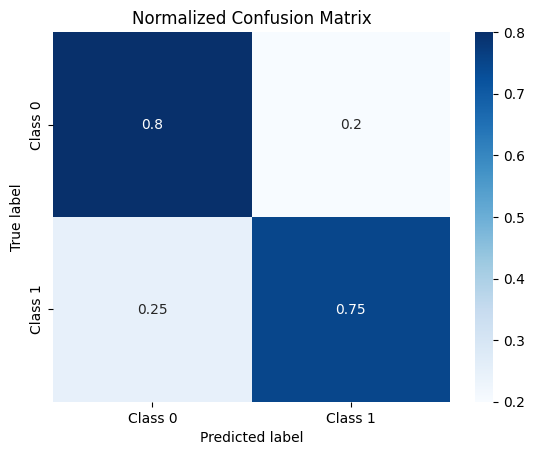

In [ ]:
import seaborn as sns

cnf_matrix = metrics.confusion_matrix(y_test_flattened, logistic_regression_predictions)
print("Confusion Matrix: \n",cnf_matrix)

# Normalize confusion matrix
cm_normalized = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
print("Normalized Confusion Matrix:\n",cm_normalized)

classes = ['Class 0', 'Class 1']

# Plot normalized confusion matrix using Seaborn
sns.heatmap(cm_normalized, annot=True, cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [ ]:
# print(y_test_flattened)
# print(y_test)

print(logistic_regression_predictions)

lr_matrix = np.zeros((logistic_regression_predictions.size, 2))

for i in range(0,logistic_regression_predictions.size):
  if(logistic_regression_predictions[i] == 1):
    lr_matrix[i][1] = 1
  else:
    lr_matrix[i][0] = 1

print(lr_matrix)

[0 0 0 1 1 1 1 0 1 0 0 0 0 1 1 0 0 1 0 0 1 0 1 0 1 1 1 0 0 1 0 1 1 1 1 0 1
 0 1 0 0 1 0 0 0 1 1 1 1 1 1 0 1 0 1 1 1 1 0 0 0 0 1 0 1 1 0 0 0 0 0 1 0 1
 0]
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]]


<ipython-input-97-bbd1ce1ec573>:33: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


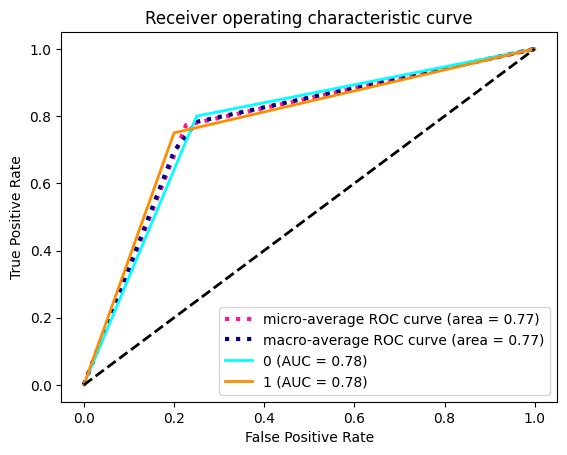

In [ ]:
from itertools import cycle
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp

def plot_AUC_ROC(y_true, y_pred):
    n_classes = 2

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


    # Compute macro-average ROC curve and ROC area

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])


    plt.plot(fpr["micro"], tpr["micro"],
            label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]),
            color='deeppink', linestyle='dotted', linewidth=3)

    plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=3)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, linewidth=2,label='{0} (AUC = {1:0.2f})'.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', linewidth=2) # Diognal line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic curve')
    plt.legend(loc="lower right")

plot_AUC_ROC(y_test,lr_matrix)

## **Prediction through AdaBoost Classifier**

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

# Create AdaBoost classifier
ada_boost_classifier = AdaBoostClassifier(n_estimators=100)

# Train the classifier
ada_boost_classifier.fit(X_train_features_flat, y_train_flattened)

# Make predictions on the test set
ada_boost_predictions = ada_boost_classifier.predict(X_test_features_flat)

# Calculate accuracy
ada_boost_accuracy = accuracy_score(y_test_flattened, ada_boost_predictions)
print("AdaBoost Accuracy:", ada_boost_accuracy)


AdaBoost Accuracy: 0.7866666666666666


In [ ]:
from sklearn import metrics

# Generate classification report with zero_division parameter set to "warn"
report = metrics.classification_report(y_test_flattened, ada_boost_predictions)

# Print the report
print(report)

              precision    recall  f1-score   support

           0       0.76      0.80      0.78        35
           1       0.82      0.78      0.79        40

    accuracy                           0.79        75
   macro avg       0.79      0.79      0.79        75
weighted avg       0.79      0.79      0.79        75



Confusion Matrix: 
 [[28  7]
 [ 9 31]]
Normalized Confusion Matrix:
 [[0.8   0.2  ]
 [0.225 0.775]]


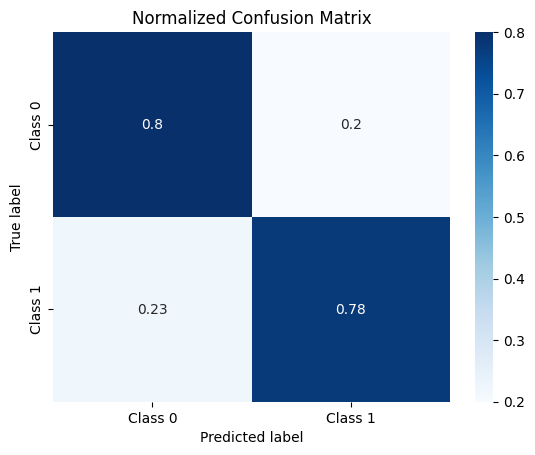

In [ ]:
import seaborn as sns

cnf_matrix = metrics.confusion_matrix(y_test_flattened,ada_boost_predictions)
print("Confusion Matrix: \n",cnf_matrix)

# Normalize confusion matrix
cm_normalized = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
print("Normalized Confusion Matrix:\n",cm_normalized)

classes = ['Class 0', 'Class 1']

# Plot normalized confusion matrix using Seaborn
sns.heatmap(cm_normalized, annot=True, cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [ ]:
print(ada_boost_predictions)

ada_matrix = np.zeros((ada_boost_predictions.size, 2))

for i in range(0,ada_boost_predictions.size):
  if(ada_boost_predictions[i] == 1):
    ada_matrix[i][1] = 1
  else:
    ada_matrix[i][0] = 1

print(ada_matrix)

[0 0 0 1 1 1 1 0 1 0 0 0 0 1 1 0 0 1 0 0 1 0 1 0 1 1 1 1 0 1 0 1 1 1 1 1 1
 0 1 0 0 1 0 0 0 1 1 1 1 1 1 0 0 0 1 1 1 1 0 0 0 0 1 0 1 1 0 0 0 0 0 1 0 1
 0]
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]]


<ipython-input-102-db04ce678cd1>:33: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


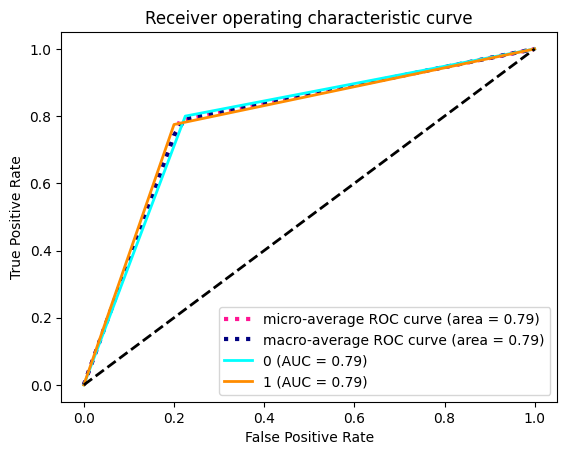

In [ ]:
from itertools import cycle
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp

def plot_AUC_ROC(y_true, y_pred):
    n_classes = 2

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


    # Compute macro-average ROC curve and ROC area

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])


    plt.plot(fpr["micro"], tpr["micro"],
            label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]),
            color='deeppink', linestyle='dotted', linewidth=3)

    plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=3)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, linewidth=2,label='{0} (AUC = {1:0.2f})'.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', linewidth=2) # Diognal line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic curve')
    plt.legend(loc="lower right")

plot_AUC_ROC(y_test,ada_matrix)

# **All Classifier Accuracy**

In [ ]:
from tabulate import tabulate

# Define the data as a list of lists, where each inner list represents a row
data = [
    ["Model", "Accuracy"],
    ["EfficientNetV2B0 Model",test_accuracy],
    ["Decision Tree", decision_tree_accuracy],
    ["Random Forest", rf_accuracy],
    ["Support Vector Machine", svm_accuracy],
    ["Naive Bayes", nb_accuracy],
    ["Logistic Regression", logistic_regression_accuracy],
    ["AdaBoost", ada_boost_accuracy]
]

sorted_data = sorted(data[2:], key=lambda x: x[1], reverse=True)
sorted_data.insert(0, data[0])
sorted_data.insert(1, data[1])

# Print the data in tabular form
print(tabulate(sorted_data, headers="firstrow", tablefmt="grid"))


+------------------------+------------+
| Model                  |   Accuracy |
+========================+============+
| EfficientNetV2B0 Model |   0.786667 |
+------------------------+------------+
| Random Forest          |   0.84     |
+------------------------+------------+
| Support Vector Machine |   0.813333 |
+------------------------+------------+
| Naive Bayes            |   0.8      |
+------------------------+------------+
| AdaBoost               |   0.786667 |
+------------------------+------------+
| Logistic Regression    |   0.773333 |
+------------------------+------------+
| Decision Tree          |   0.613333 |
+------------------------+------------+
